# Загрузка библиотек

In [332]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
from sklearn.cluster import DBSCAN
from sklearn.model_selection import train_test_split

df = pd.read_csv('meat_consumption_worldwide.csv')

# Обработка данных

In [333]:
df

,LOCATION,SUBJECT,MEASURE,TIME,Value
0,AUS,BEEF,KG_CAP,1991,27.721815
1,AUS,BEEF,KG_CAP,1992,26.199591
2,AUS,BEEF,KG_CAP,1993,26.169094
3,AUS,BEEF,KG_CAP,1994,25.456134
4,AUS,BEEF,KG_CAP,1995,25.340226
...,...,...,...,...,...
13755,MYS,SHEEP,THND_TONNE,2022,44.154151
13756,MYS,SHEEP,THND_TONNE,2023,44.897588
13757,MYS,SHEEP,THND_TONNE,2024,45.612107
13758,MYS,SHEEP,THND_TONNE,2025,46.325312


In [334]:
for column in ['SUBJECT', 'MEASURE']:
    print(df[column].unique())

['BEEF' 'PIG' 'POULTRY' 'SHEEP']
['KG_CAP' 'THND_TONNE']


Датасет содержит данные о ежегодном потреблении мяса в разных странах мира. Представлены следующие столбцы:
* Код страны
* Тип мяса (говядина, свинина, птица, баранина)
* Единицы измерения (килограмм на душу населения, тыс. тонн на все население)
* Год
* Количество

Для удобства оставим только одну единицу измерения - килограмм на душу населения, а также уберем из рассмотрения 2019-2026 годы, так как для данного датасета они являются прогнозными.

In [335]:
df = df[(df.MEASURE == 'KG_CAP') & (df.TIME < 2019)].drop('MEASURE', axis=1)
df

,LOCATION,SUBJECT,TIME,Value
0,AUS,BEEF,1991,27.721815
1,AUS,BEEF,1992,26.199591
2,AUS,BEEF,1993,26.169094
3,AUS,BEEF,1994,25.456134
4,AUS,BEEF,1995,25.340226
...,...,...,...,...
6705,EU28,SHEEP,2014,1.808892
6706,EU28,SHEEP,2015,1.919364
6707,EU28,SHEEP,2016,1.941403
6708,EU28,SHEEP,2017,1.936038


Посмотрим на столбец со странами.

In [336]:
df.LOCATION.unique()

array(['AUS', 'CAN', 'JPN', 'KOR', 'MEX', 'NZL', 'TUR', 'USA', 'DZA',
       'ARG', 'BGD', 'BRA', 'CHL', 'CHN', 'COL', 'EGY', 'ETH', 'GHA',
       'HTI', 'IND', 'IDN', 'IRN', 'ISR', 'KAZ', 'MYS', 'MOZ', 'NGA',
       'PAK', 'PRY', 'PER', 'PHL', 'RUS', 'SAU', 'ZAF', 'SDN', 'TZA',
       'THA', 'UKR', 'URY', 'VNM', 'ZMB', 'WLD', 'SSA', 'OECD', 'BRICS',
       'EU28'], dtype=object)

Здесь есть не только страны по отдельности, но и объединения стран. Мы будем работать со статистикой по отдельным странам.

In [337]:
df = df[~df.LOCATION.isin(['WLD', 'SSA', 'OECD', 'BRICS', 'EU28'])]
df

,LOCATION,SUBJECT,TIME,Value
0,AUS,BEEF,1991,27.721815
1,AUS,BEEF,1992,26.199591
2,AUS,BEEF,1993,26.169094
3,AUS,BEEF,1994,25.456134
4,AUS,BEEF,1995,25.340226
...,...,...,...,...
6012,ZMB,SHEEP,2014,0.559749
6013,ZMB,SHEEP,2015,0.542815
6014,ZMB,SHEEP,2016,0.526400
6015,ZMB,SHEEP,2017,0.521667


В данном проекте мы не будем работать с динамикой временных рядов, поэтому просто усредним количество мяса по каждой стране за заданный период.

In [338]:
df = df.drop('TIME', axis=1).groupby(['LOCATION', 'SUBJECT'], as_index=False).mean()
df

,LOCATION,SUBJECT,Value
0,ARG,BEEF,44.160206
1,ARG,PIG,5.859597
2,ARG,POULTRY,25.016873
3,ARG,SHEEP,1.412952
4,AUS,BEEF,24.894956
...,...,...,...
159,ZAF,SHEEP,3.368349
160,ZMB,BEEF,4.979891
161,ZMB,PIG,1.092755
162,ZMB,POULTRY,2.646815


Затем разобьем столбец с типом мяса на четыре, соответствующих каждому типу.

In [339]:
df2 = pd.DataFrame()
for i in df.SUBJECT.unique():
    df2[[i]] = pd.DataFrame(df[df.SUBJECT == i].reset_index().drop('index', axis=1).Value)
df2

,BEEF,PIG,POULTRY,SHEEP
0,44.160206,5.859597e+00,25.016873,1.412952
1,24.894956,1.770147e+01,32.295111,12.811150
2,0.910389,7.786962e-07,0.963715,0.973671
3,23.941474,9.168299e+00,28.922041,0.458091
4,21.546241,1.952596e+01,31.108514,0.865758
5,15.487974,1.410871e+01,24.878019,0.628469
6,2.803289,2.542092e+01,8.894310,2.098320
7,12.338166,3.209942e+00,17.156790,0.260886
8,3.585669,7.147841e-02,6.629355,5.723593
9,7.567136,7.527061e-02,7.850649,1.224160


Так выглядит итоговый датасет, готовый к дальнейшей работе.

# Построение и оценка модели

Так как мы не можем построить четырехмерный график, построим два scatter-plot.

<Axes: xlabel='BEEF', ylabel='PIG'>

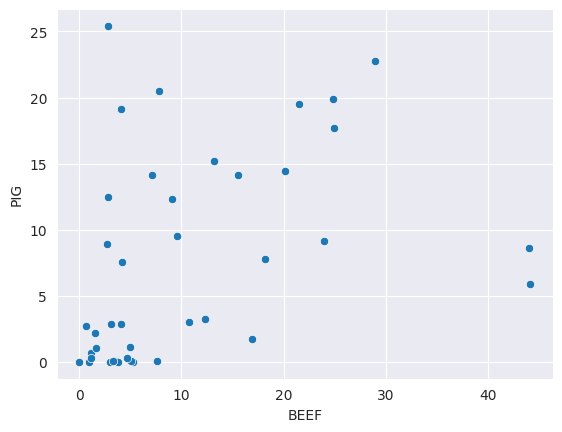

In [340]:
sns.scatterplot(x=df2.BEEF, y=df2.PIG)

<Axes: xlabel='SHEEP', ylabel='POULTRY'>

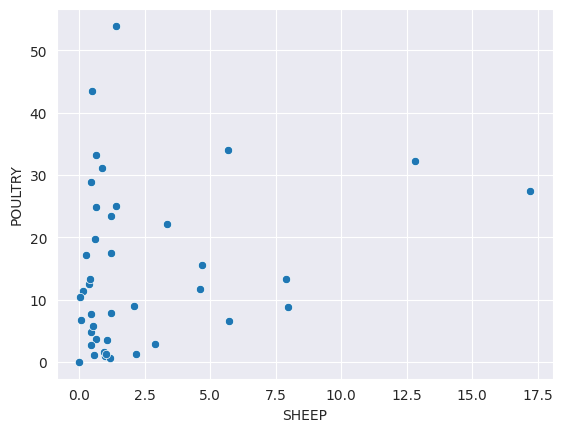

In [341]:
sns.scatterplot(x=df2.SHEEP, y=df2.POULTRY)

В данном проекте будем решать задачу кластеризации. Попробуем объединить потребителей мяса в группы.

Обучим модель DBSCAN и начертим точечные диаграммы для наглядной визуализации кластеров.

<Axes: xlabel='SHEEP', ylabel='POULTRY'>

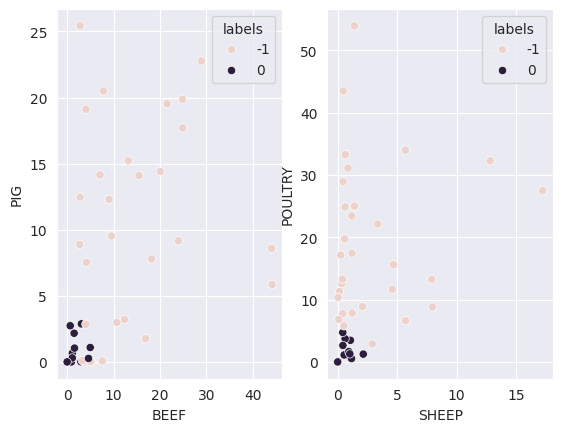

In [342]:
train, test = train_test_split(df2, test_size=0.25)
db = DBSCAN(eps=2.5, min_samples=2).fit(df2)
df2[['labels']] = pd.DataFrame(db.labels_)
fig, axes = plt.subplots(1, 2)
sns.scatterplot(df2, x=df2.BEEF, y=df2.PIG, hue='labels', ax=axes[0])
sns.scatterplot(df2, x=df2.SHEEP, y=df2.POULTRY, hue='labels', ax=axes[1])

Для параметра min_samples было выбрано значение 2 в силу разброса данных. С eps все не так однозначно: сложно судить о качестве четырехмерного кластера по двум двумерным проекциям. В любом случае получается большое количество выбросов, не принадлежащее никакому из кластеров.

Используем в качестве метрики Silhouette Score и заново проведем вычисления, подбирая параметр eps.

In [343]:
df2.drop('labels', axis=1, inplace=True)
eps = [1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5, 5.5, 6, 6.5, 7, 7.5, 8]

for i in eps:
    db = DBSCAN(eps=i, min_samples=2).fit(df2)
    print(i, ':', silhouette_score(df2, db.labels_))

Исходя из полученных данных, лучшим значением для параметра eps является 8. Оценка silhouette score при этом является не слишком высокой. Однако, если снова взглянуть на графики, кластеры выглядят вполне неплохо.

<Axes: xlabel='SHEEP', ylabel='POULTRY'>

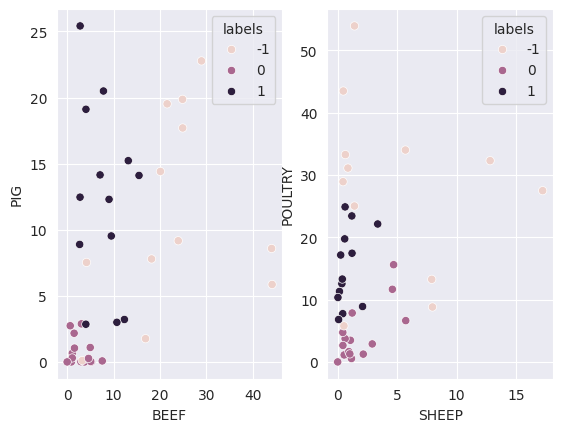

In [346]:
db = DBSCAN(eps=8, min_samples=2).fit(df2)
df2[['labels']] = pd.DataFrame(db.labels_)
fig, axes = plt.subplots(1, 2)
sns.scatterplot(df2, x=df2.BEEF, y=df2.PIG, hue='labels', ax=axes[0])
sns.scatterplot(df2, x=df2.SHEEP, y=df2.POULTRY, hue='labels', ax=axes[1])

Имеем кластер стран с низким потреблением мяса, кластер стран с малым потреблением говядины и баранины, но с высоким потреблением птицы и свинины, и кластер выбросов.

Чтобы посмотреть на представителей кластеров, добавим столбец с соответствующей локацией.

In [347]:
df2[['location']] = pd.DataFrame(df.LOCATION.unique())
df2.head()

,BEEF,PIG,POULTRY,SHEEP,labels,location
0,44.160206,5.859597e+00,25.016873,1.412952,-1,ARG
1,24.894956,1.770147e+01,32.295111,12.811150,-1,AUS
2,0.910389,7.786962e-07,0.963715,0.973671,0,BGD
3,23.941474,9.168299e+00,28.922041,0.458091,-1,BRA
4,21.546241,1.952596e+01,31.108514,0.865758,-1,CAN


In [348]:
df2[df2.labels == 0]

,BEEF,PIG,POULTRY,SHEEP,labels,location
2,0.910389,7.786962e-07,0.963715,0.973671,0,BGD
8,3.585669,7.147841e-02,6.629355,5.723593,0,DZA
9,7.567136,7.527061e-02,7.850649,1.224160,0,EGY
10,2.965468,1.587546e-02,0.550313,1.165560,0,ETH
11,1.117032,6.610262e-01,3.473163,1.074670,0,GHA
12,3.072248,2.880927e+00,3.731751,0.630886,0,HTI
13,1.510565,2.169866e+00,4.727910,0.435685,0,IDN
14,1.104198,2.994260e-01,1.121255,0.552011,0,IND
15,3.755635,7.168999e-04,15.601911,4.702170,0,IRN
21,0.669865,2.736866e+00,1.657612,0.944054,0,MOZ


Например, для кластера 0 имеем бедные страны, такие как Бангладеш, Гана, Гаити.
Интересно увидеть, что для мусульманских стран, таких как Пакистан, Судан и Турция потребление свинины на несколько порядков ниже потребления других видов мяса. Модель упустила данную особенность.

In [349]:
df2[df2.labels == 1]

,BEEF,PIG,POULTRY,SHEEP,labels,location
5,15.487974,14.108707,24.878019,0.628469,1,CHL
6,2.803289,25.420920,8.894310,2.098320,1,CHN
7,12.338166,3.209942,17.156790,0.260886,1,COL
17,7.099483,14.149524,12.547138,0.359957,1,JPN
19,7.825199,20.496183,11.307097,0.155963,1,KOR
20,9.513554,9.529725,19.746912,0.596822,1,MEX
26,4.034025,2.851327,23.426855,1.194633,1,PER
27,2.784448,12.465287,7.742650,0.431509,1,PHL
29,13.175229,15.226500,17.443311,1.212562,1,RUS
32,2.702809,8.889621,10.342786,0.028387,1,THA


Кластер 1 с уменьшенным потреблением баранины и говядины представлен в большинстве своем азиатскими странами, некоторыми южноамериканскими, а также восточноевропейскими.

In [350]:
df2[df2.labels == -1]

,BEEF,PIG,POULTRY,SHEEP,labels,location
0,44.160206,5.859597,25.016873,1.412952,-1,ARG
1,24.894956,17.701465,32.295111,12.811150,-1,AUS
3,23.941474,9.168299,28.922041,0.458091,-1,BRA
4,21.546241,19.525963,31.108514,0.865758,-1,CAN
16,16.896158,1.758941,53.917270,1.417713,-1,ISR
18,18.190027,7.790403,8.814770,7.969053,-1,KAZ
22,4.178733,7.528422,33.266998,0.652111,-1,MYS
24,20.097341,14.411213,27.482859,17.222887,-1,NZL
28,24.862690,19.865967,5.786662,0.531300,-1,PRY
30,3.265686,0.103641,34.002202,5.695045,-1,SAU


Интересно посмотреть и на выбросы, поскольку несмотря на отсутствие принадлежности к определенному кластеру можно увидеть самые мощные страны-мясоеды.

Таким образом, мы получили модель, с помощью которой можно понять культурную принадлежность той или иной страны на основании предпочтительного вида мяса.